In [1]:
#Let's start a temporary environment for this notebook, and add julia packages that we will 
if !isdefined(Main,:MeshArrays)
    using Pkg; Pkg.activate(temp=true)
    Pkg.add.(["MeshArrays", "Climatology", "Statistics","JLD2", "Downloads", 
            "DataDeps", "ZipFile", "PlutoUI","CairoMakie", "Proj", "GeoJSON", "Shapefile"])
end

#Then the using command turns on the Julia packages
using MeshArrays, Climatology, Statistics, JLD2, Downloads
using DataDeps, ZipFile, PlutoUI, CairoMakie, Proj, GeoJSON, Shapefile

  Activating new project at `/tmp/jl_aZck0Q`
   Resolving package versions...
    Updating `/tmp/jl_aZck0Q/Project.toml`
  [cb8c808f] + MeshArrays v0.3.21
    Updating `/tmp/jl_aZck0Q/Manifest.toml`
  [81a5f4ea] + CatViews v1.0.0
  [b4f34e82] + Distances v0.10.12
  [c27321d9] + Glob v1.3.1
  [cb8c808f] + MeshArrays v0.3.21
  [b8a86587] + NearestNeighbors v0.4.21
⌅ [aea7be01] + PrecompileTools v1.2.1
  [21216c6a] + Preferences v1.4.3
  [90137ffa] + StaticArrays v1.9.13
  [1e83bf80] + StaticArraysCore v1.4.3
  [10745b16] + Statistics v1.11.1
  [82ae8749] + StatsAPI v1.7.0
  [1986cc42] + Unitful v1.22.1
  [0dad84c5] + ArgTools v1.1.2
  [56f22d72] + Artifacts v1.11.0
  [2a0f44e3] + Base64 v1.11.0
  [ade2ca70] + Dates v1.11.0
  [8ba89e20] + Distributed v1.11.0
  [f43a241f] + Downloads v1.6.0
  [7b1f6079] + FileWatching v1.11.0
  [b77e0a4c] + InteractiveUtils v1.11.0
  [4af54fe1] + LazyArtifacts v1.11.0
  [b27032c2] + LibCURL v0.6.4
  [76f85450] + LibGit2 v1.11.0
  [8f399da3] + Libdl v1.11.0

In [2]:
#read ECCO4 grid (LLC90)
pth=MeshArrays.GRID_LLC90
γ=GridSpec(ID=:LLC90)
Γ=GridLoad(γ;option="light")	

#define grid paths, sections, ocean basins
LC=LatitudeCircles(-89.0:89.0,Γ)
basins=demo.ocean_basins()
sections,path_sec=demo.ocean_sections(Γ);

In [3]:
# Interpolate Γ.Depth to regular grid:
λ=interpolation_setup()
hFacC=GridLoadVar("hFacC",γ)
μ=land_mask(hFacC[:,1])
	
Depth_interpolated=Interpolate(λ.μ*Γ.Depth,λ.f,λ.i,λ.j,λ.w)
Depth_interpolated=reshape(Depth_interpolated,size(λ.lon));
#Depth_interpolated[findall(Depth_interpolated.==0.0)].=NaN

In [4]:
nn=30    
τ=Tiles(γ,nn,nn)
XC_tiled=Tiles(τ,Γ.XC)
YC_tiled=Tiles(τ,Γ.YC)
Depth_tiled=Tiles(τ,Γ.Depth);

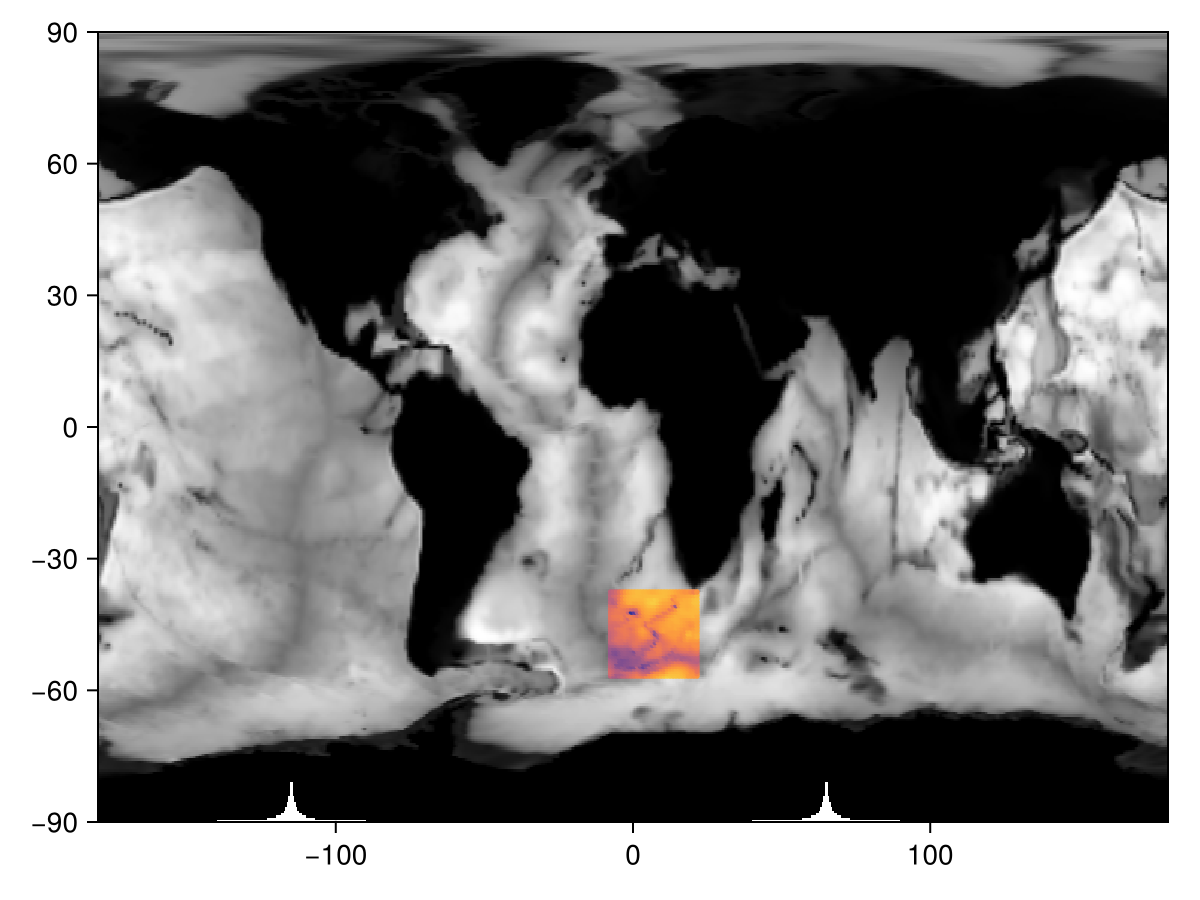

In [5]:
ii=11
fi=heatmap(Γ.Depth,interpolation=λ,colormap=:grayC,colorbar=false)
scatter!(current_axis(),XC_tiled[ii][:],YC_tiled[ii][:],color=Depth_tiled[ii][:],
    markersize=4.0,colormap=:thermal,colorrange=(0.0,6000.0))
fi

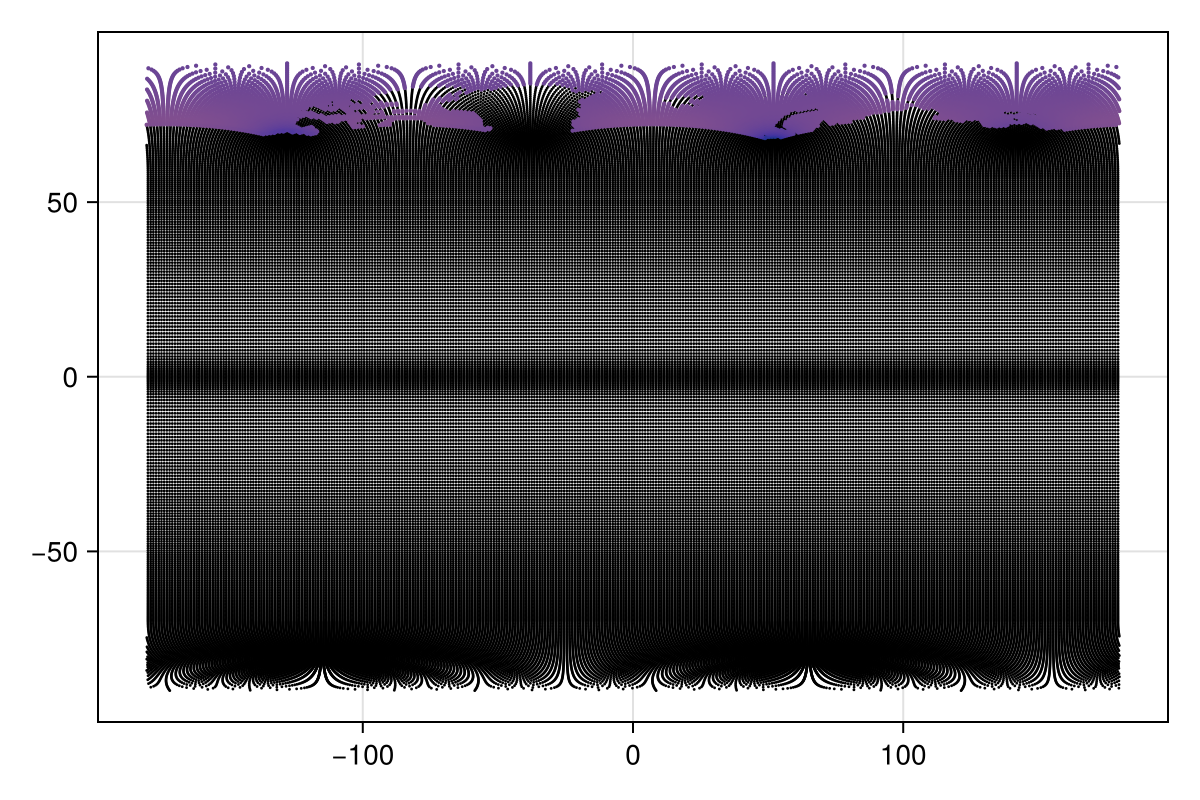

In [6]:
faceID=3
fi=Figure(size=(600,400)); ax=Axis(fi[1,1]); scatter!(ax,Γ.XC,Γ.YC,color=:black,markersize=2.0); MS=log10.(Γ.RAC)*μ; 
scatter!(ax,Γ.XC[faceID][:],Γ.YC[faceID][:],color=MS[faceID][:], colorrange = (8.8,10.2),markersize=3.0,colormap=:thermal)
fi

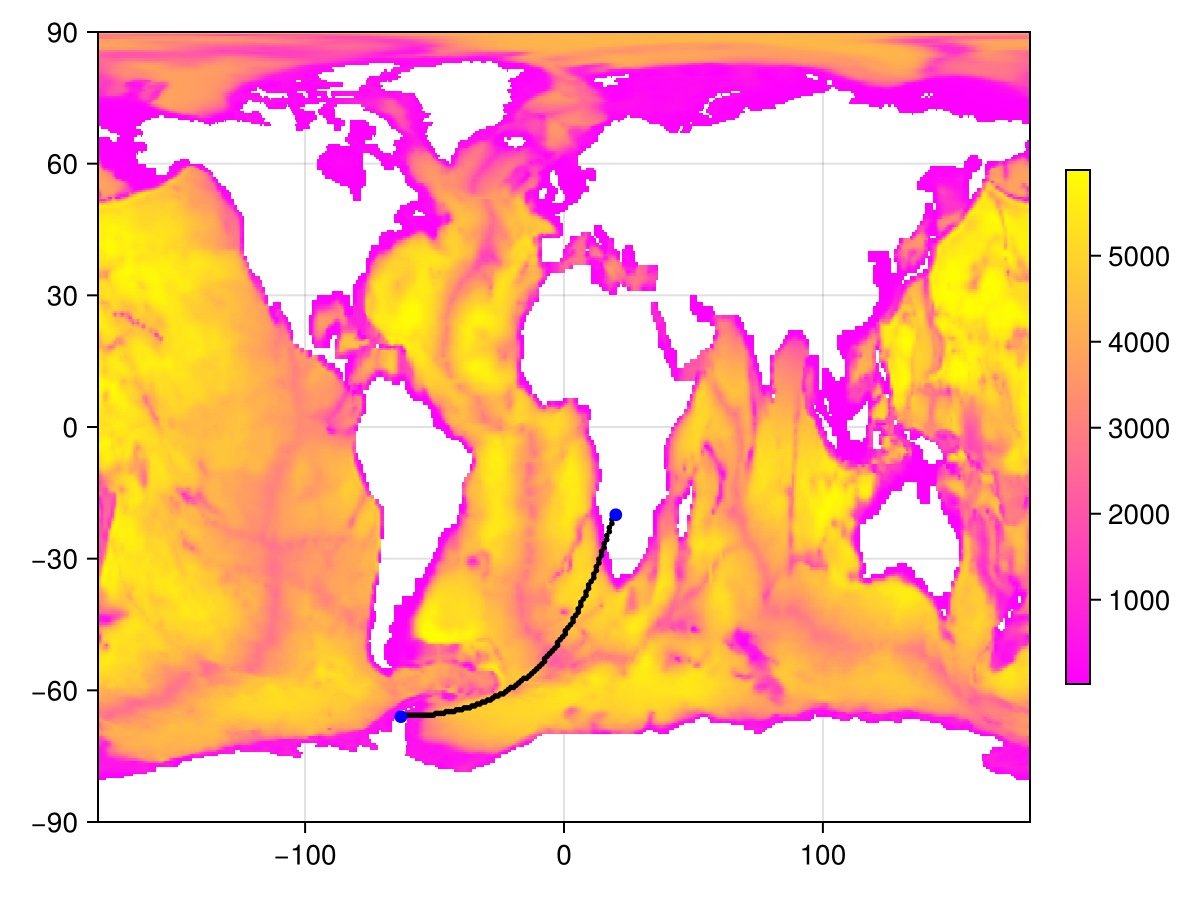

In [7]:
lon1=20.0; lon2=-63.0; lat1=-20.0; lat2=-66.0
lons=[lon1 lon2]; lats=[lat1 lat2]
my_section=demo.one_section(Γ,lons,lats)

fig_section=heatmap(λ.μ*Γ.Depth,interpolation=λ,colormap=:spring); ax=current_axis(fig_section)
scatter!(ax,my_section.lon[:],my_section.lat[:],color=:blue,markersize=2.0)
scatter!(ax,my_section.lon[:],my_section.lat[:],color=:black,markersize=4.0)
scatter!(ax,lons[:],lats[:],color=:blue)
fig_section

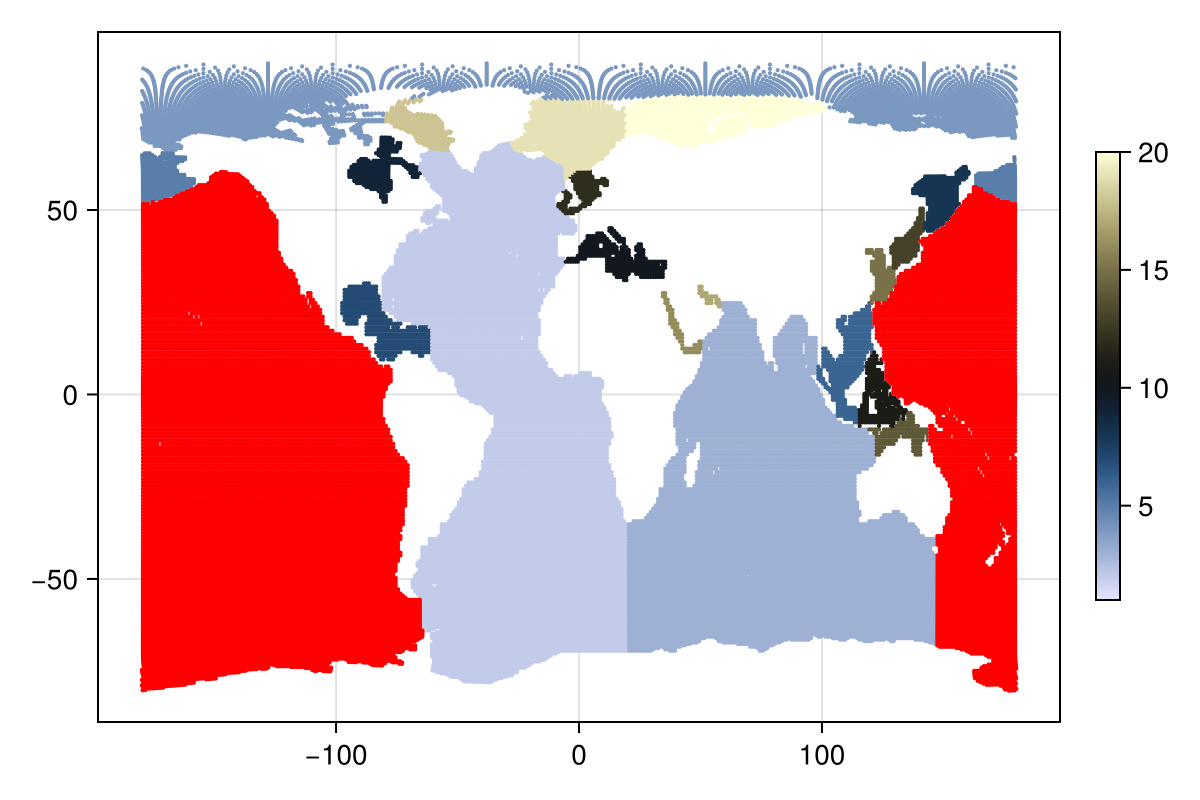

In [8]:
basin_ID=1
jj=findall(basins.mask.==basin_ID)
fi=Figure(size=(600,400)); ax=Axis(fi[1,1]); 
scatter!(ax,Γ.XC,Γ.YC,color=basins.mask*μ,colormap=:lisbon,markersize=3.0)
[scatter!(ax,Γ.XC[jj][k],Γ.YC[jj][k],color=:red,markersize=3) for k in 1:length(jj)] 
fi

In [9]:
#read polygons for plotting

#fil=demo.download_polygons("ne_110m_admin_0_countries.shp")
fil=demo.download_polygons("countries.geojson")
pol=MeshArrays.read_polygons(fil);

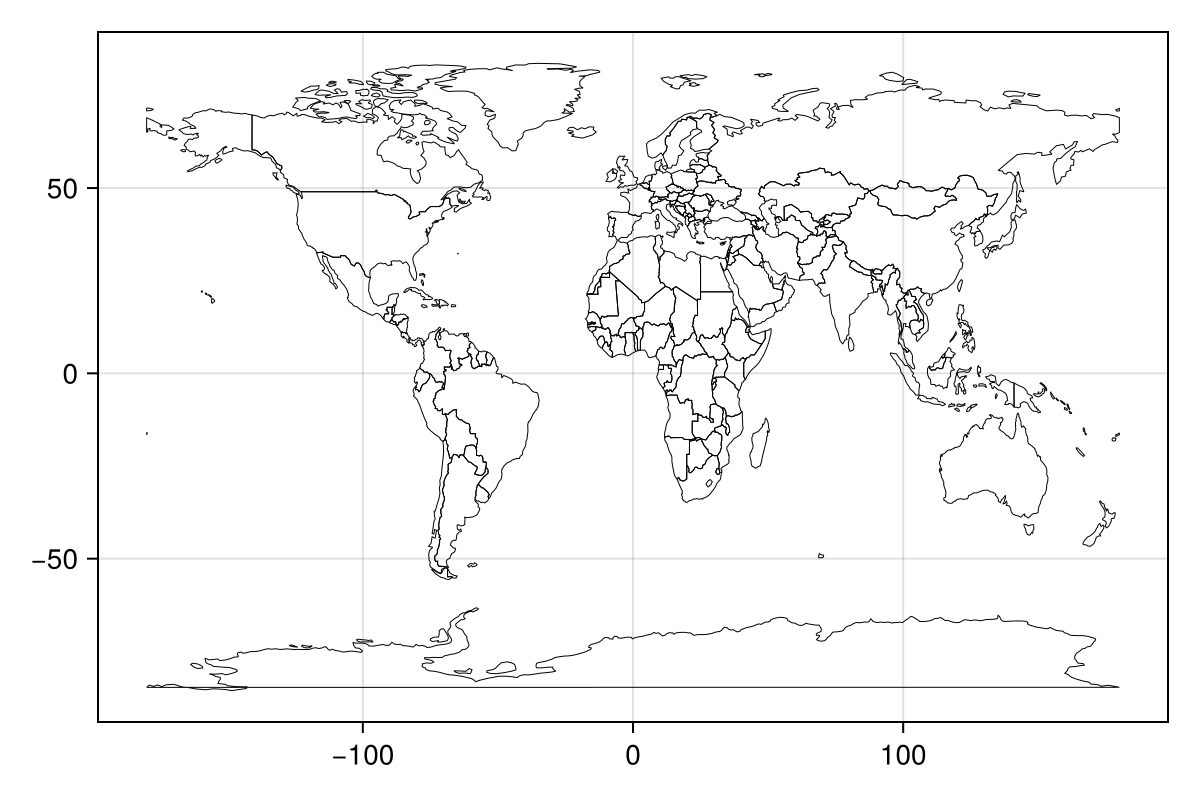

In [10]:
fig_polygons=Figure(size=(600,400))
ax1=Axis(fig_polygons[1,1])
[lines!(ax1,l1,color = :black, linewidth = 0.5) for l1 in pol]
fig_polygons

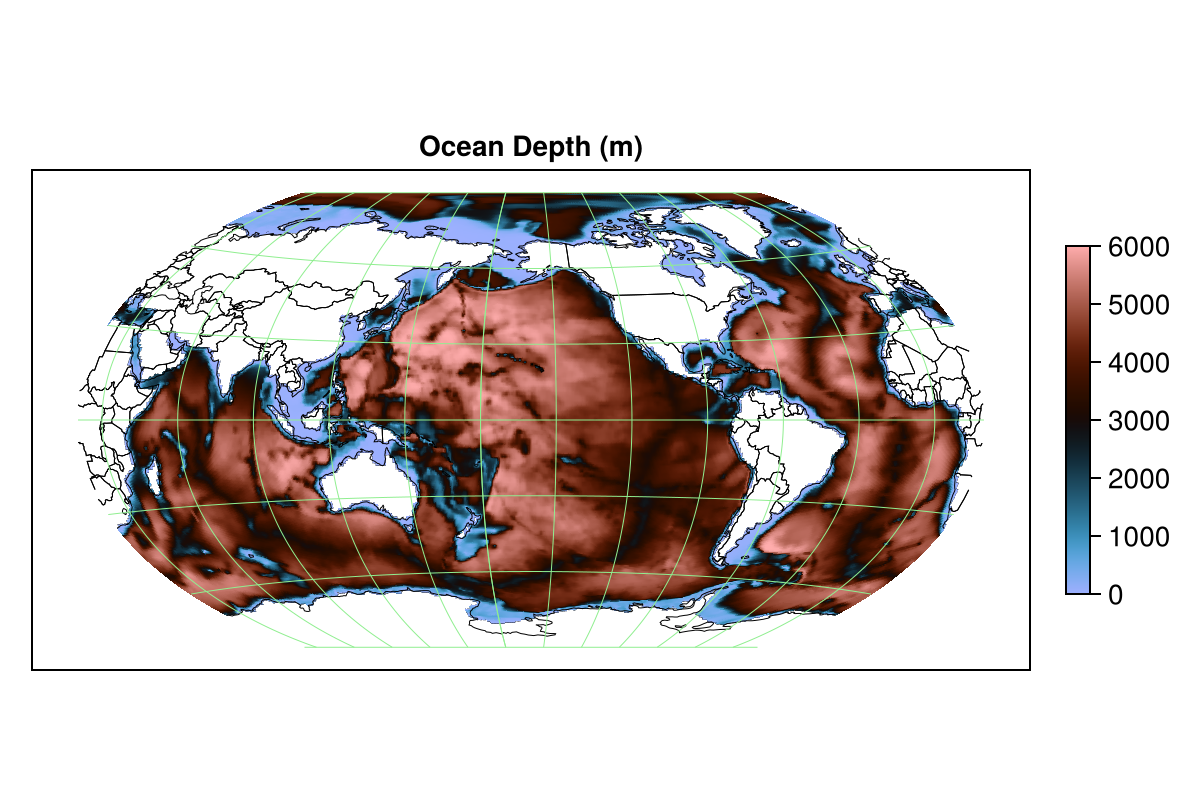

In [11]:
meta=(colorrange=(0.0,6000.0),cmap=:berlin,gridcolor=:lightgreen,ttl="Ocean Depth (m)")
data=(lon=λ.lon,lat=λ.lat,var=Depth_interpolated,meta=meta,polygons=pol)

proj_ID=1; lon0=-160.0
proj_name=["wintri","natearth2","longlat"]
proj=Proj.Transformation(MA_preset=proj_ID,lon0=lon0)

fig0=let
    f = Figure(size=(600,400))
    ax = f[1, 1] = Axis(f, aspect = DataAspect(), title = "Ocean Depth (m)")
    
    pr_ax=MeshArrays.ProjAxis(ax; proj=proj,lon0=lon0)
    
    surf = surface!(pr_ax,λ.lon,λ.lat,0*λ.lat; color=Depth_interpolated, 
            colorrange=(0.0,6000.0), colormap=:berlin, shading = NoShading)
    lines!(pr_ax; polygons=pol,color=:black,linewidth=0.5)
    #y1=-90:5:90; x1=lon0.+0*y1; scatter!(pr_ax,x1,y1,color=:yellow,markersize=5,marker=:x)
    MeshArrays.grid_lines!(pr_ax;color=:lightgreen,linewidth=0.5)
    
    Colorbar(f[1,2], surf, height = Relative(0.5))
    f
end

In [12]:
LC=LatitudeCircles(79.0,Γ)
aa=LC.C
locClat=( lon=[Γ.XC[aa[i,1]][aa[i,2],aa[i,3]] for i in 1:size(aa,1)],
            lat=[Γ.YC[aa[i,1]][aa[i,2],aa[i,3]] for i in 1:size(aa,1)])
"Done with latitude line"

"Done with latitude line"

In [13]:
(fig1,fig2,fig3)=MeshArrays.plot_examples(:interpolation_demo,Γ);